# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-10 12:12:38.144505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 12:12:38.144624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 12:12:38.282343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data exploration 

## Plotting example images

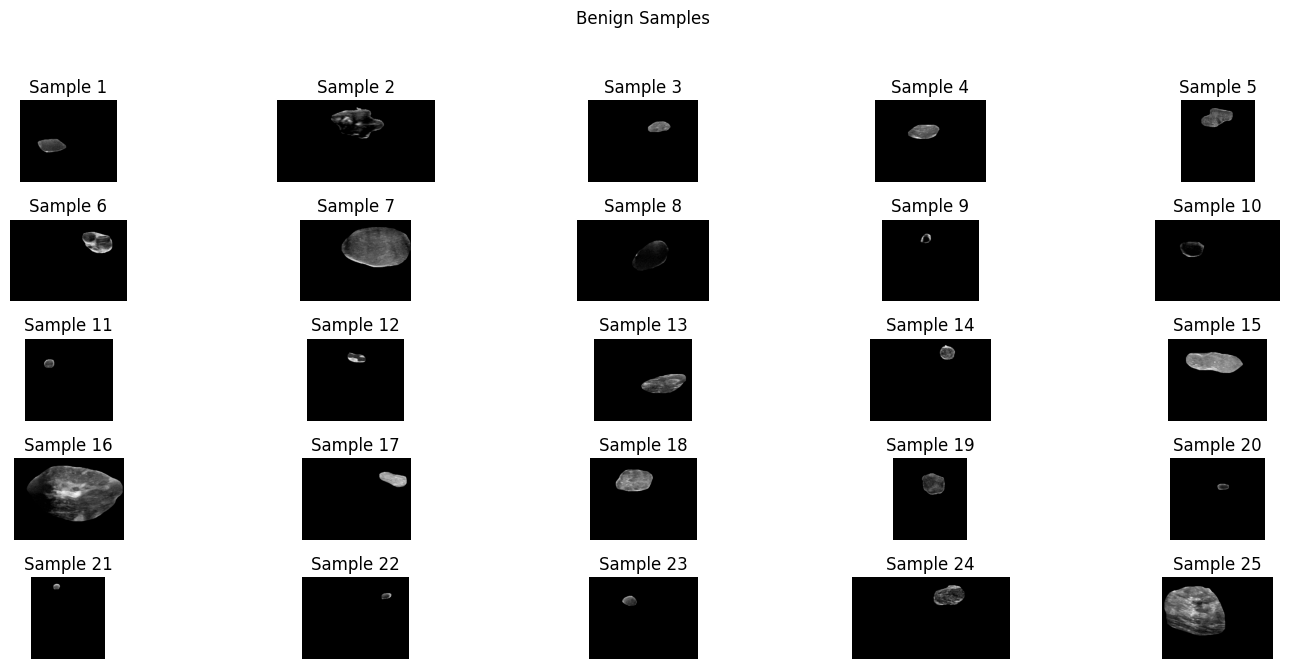

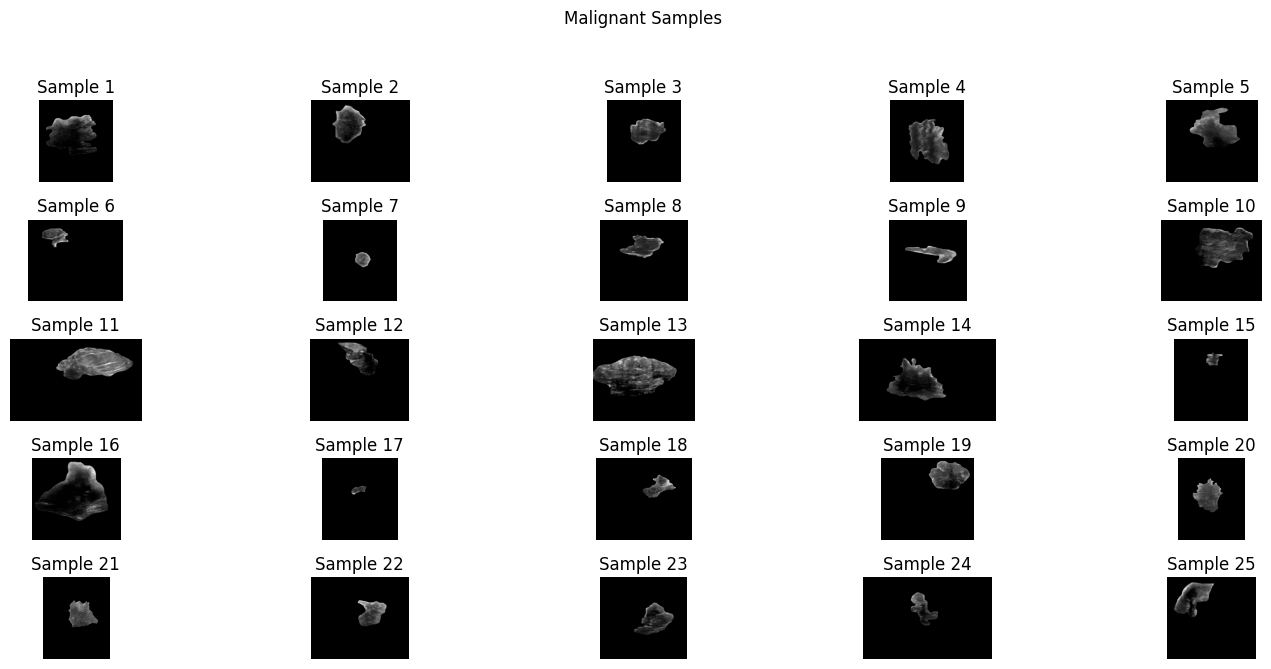

In [2]:
def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
plot_class_samples(training_path, 'benign', num_samples=25)

plot_class_samples(training_path, 'malignant', num_samples=25)

In [3]:
def create_classification_df(base_path):
    categories = ['benign', 'malignant'] 
    data = [] 

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]
        
        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': f, 'classification': category} for f in image_files])
   
    df = pd.DataFrame(data)
    return df

training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'
train_df = create_classification_df(training_path)
test_df = create_classification_df(test_path)

df = pd.concat([train_df, test_df])
print(train_df.shape)
print(test_df.shape)
print(df.head())

(668, 2)
(100, 2)
           filename classification
0    benign (2).png         benign
1       case037.png         benign
2  benign (390).png         benign
3  benign (357).png         benign
4       case231.png         benign


## Is there a class imbalance? 

In [4]:
print(train_df['classification'].value_counts())
print(test_df['classification'].value_counts())

classification
benign       442
malignant    226
Name: count, dtype: int64
classification
benign       50
malignant    50
Name: count, dtype: int64


# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [5]:
training_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Training_data'
test_path = '/kaggle/input/breast-lesion-dataset-wo-marks3/Breast_lesion_dataset3/Test_data'


# parameters
batch_size = 32
img_height = 224  
img_width = 224   

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='binary',
    class_names=['benign', 'malignant'],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    label_mode='binary',
    image_size=(224, 224), 
    color_mode='grayscale', 
    batch_size=32)  

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.
Found 100 files belonging to 2 classes.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Baseline model


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers


model = Sequential()


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same",input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)) )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10


2024-05-10 12:13:24.296458: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.08371, expected 0.622453
2024-05-10 12:13:24.296519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.03666, expected 1.5754
2024-05-10 12:13:24.296528: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.08074, expected 1.61949
2024-05-10 12:13:24.296536: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.6191, expected 1.15784
2024-05-10 12:13:24.296544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.70133, expected 1.24007
2024-05-10 12:13:24.296552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.8675, expected 1.40624
2024-05-10 12:13:24.296559: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.81686, expected 1.3556
2024-05-10 12:13:24.296572: E external/local_xla/xla/servi

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5195 - loss: 10.5150

I0000 00:00:1715343209.710388     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5348 - loss: 6.7827

2024-05-10 12:13:30.908184: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.33115, expected 0.467215
2024-05-10 12:13:30.908261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.3149, expected 1.45096
2024-05-10 12:13:30.908276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.89817, expected 2.03423
2024-05-10 12:13:30.908288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.57407, expected 1.71013
2024-05-10 12:13:30.908302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.29753, expected 1.43359
2024-05-10 12:13:30.908319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.27941, expected 1.41547
2024-05-10 12:13:30.908330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.56697, expected 1.70303
2024-05-10 12:13:30.908340: E external/local_xla/xla/se

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5367 - loss: 6.6380

2024-05-10 12:13:35.877609: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.67034, expected 0.783926
2024-05-10 12:13:35.877669: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.21481, expected 1.3284
2024-05-10 12:13:35.877680: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.56631, expected 1.6799
2024-05-10 12:13:35.877688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.34798, expected 1.46157
2024-05-10 12:13:35.877697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.92427, expected 1.03786
2024-05-10 12:13:35.877705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.3544, expected 1.46799
2024-05-10 12:13:35.877715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.69556, expected 1.80915
2024-05-10 12:13:35.877724: E external/local_xla/xla/serv

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step - accuracy: 0.5383 - loss: 6.5094 - val_accuracy: 0.6842 - val_loss: 1.6425
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6416 - loss: 1.8103 - val_accuracy: 0.6842 - val_loss: 9.5227
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7050 - loss: 4.1420 - val_accuracy: 0.6992 - val_loss: 4.2734
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7017 - loss: 2.9505 - val_accuracy: 0.6316 - val_loss: 12.3096
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6810 - loss: 2.0809 - val_accuracy: 0.6466 - val_loss: 1.2438
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6743 - loss: 1.0588 - val_accuracy: 0.6992 - val_loss: 0.9802
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6693 - loss: 1.3419 - val_accuracy: 0.6692 - val_loss: 0.8044
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7052 - loss: 0.7732 - val_accuracy: 0.6842 - val_loss:

In [8]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [9]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()


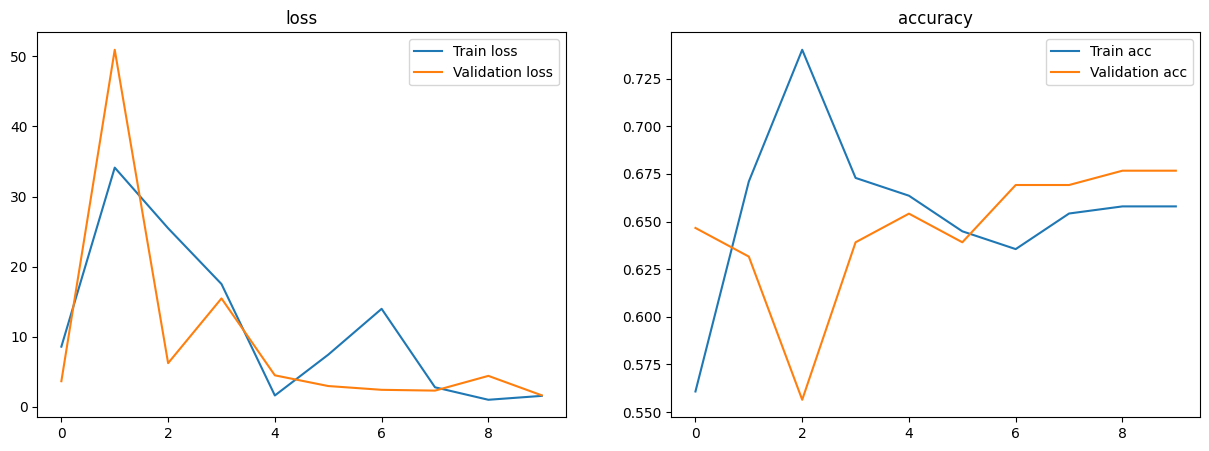

In [25]:
plot_history(history)

## Data Augmentation

### Building the model

In [26]:
model_2 = Sequential()


# Data Augmentation Layers

model_2.add(layers.RandomFlip("horizontal"))
model_2.add(layers.RandomZoom(0.1))
model_2.add(layers.RandomTranslation(0.2, 0.2))
model_2.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_2.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation="relu"))


model_2.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model_2.fit(dataset,
                    validation_data=validation_dataset,
                    epochs=10)

# Evaluate the model
loss, accuracy = model_2.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5019 - loss: 1.8185 - val_accuracy: 0.7143 - val_loss: 0.6541
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6639 - loss: 0.6516 - val_accuracy: 0.6992 - val_loss: 0.6228
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6653 - loss: 0.5903 - val_accuracy: 0.6992 - val_loss: 0.6046
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6865 - loss: 0.6215 - val_accuracy: 0.6992 - val_loss: 0.5669
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6873 - loss: 0.5792 - val_accuracy: 0.7143 - val_loss: 0.5644
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6660 - loss: 0.5566 - val_accuracy: 0.6917 - val_loss: 0.5715
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7083 - loss: 0.5378 - val_accuracy: 0.7594 - val_loss: 0.5205
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7329 - loss: 0.5355 - val_accuracy: 0.7820 - 

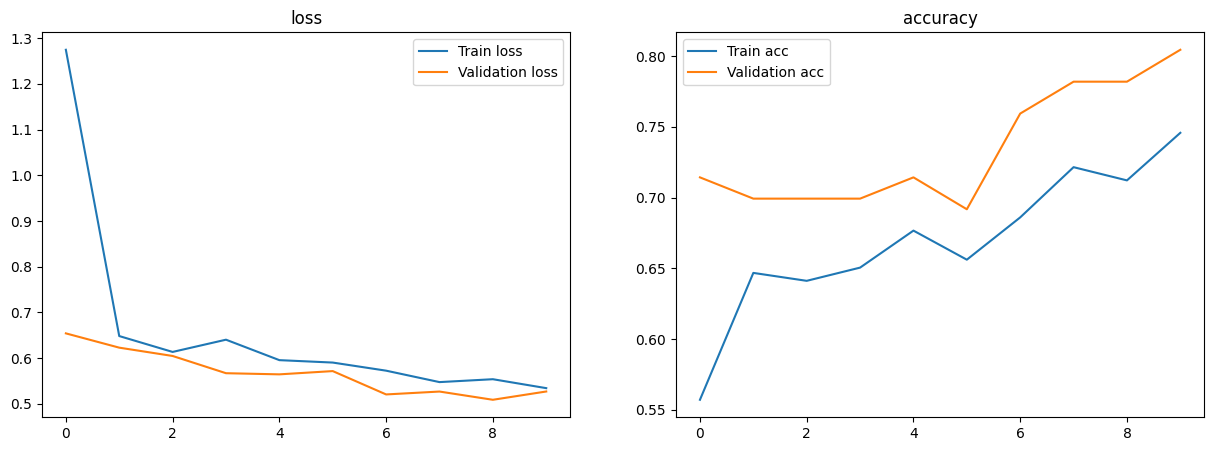

In [27]:
plot_history(history2)

In [32]:

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping



model_3 = Sequential()


# Data Augmentation Layers

model_3.add(layers.RandomFlip("horizontal"))
model_3.add(layers.RandomZoom(0.1))
model_3.add(layers.RandomTranslation(0.2, 0.2))
model_3.add(layers.RandomRotation(0.1))



# Convolutional Layers

model_3.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same", input_shape=(img_height, img_width, 1)))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))


model_3.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_3.add(layers.Flatten())

model_3.add(layers.Dense(64, activation="relu"))


model_3.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)




# Train the model
history3 = model_3.fit(dataset, validation_data=validation_dataset, epochs=1000,batch_size=32, callbacks=[model_checkpoint, lr_reducer, early_stopper])



# Evaluate the model
loss, accuracy = model_3.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5655 - loss: 2.4679 - val_accuracy: 0.6917 - val_loss: 0.6653 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6569 - loss: 0.6555 - val_accuracy: 0.6917 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6804 - loss: 0.6303 - val_accuracy: 0.7143 - val_loss: 0.5923 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6789 - loss: 0.5962 - val_accuracy: 0.7143 - val_loss: 0.5789 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7048 - loss: 0.5599 - val_accuracy: 0.7444 - val_loss: 0.6497 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6832 - loss: 0.5773 - val_accuracy: 0.6842 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6774 - loss: 0.

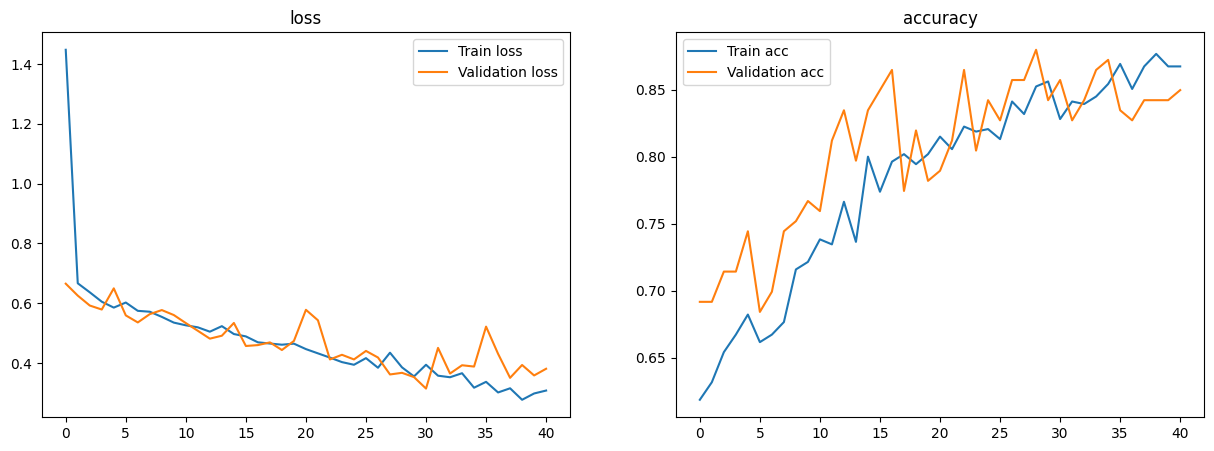

In [33]:
plot_history(history3)

In [34]:
# Evaluate the model on test_dataset
loss, accuracy = model_3.evaluate(test_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9008 - loss: 0.2989
Validation Loss: 0.3342404067516327
Validation Accuracy: 0.8899999856948853


## EfficientNetB2

In [11]:

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)


# Load the test dataset
test_dataset_rgb  = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    shuffle=True,
    image_size=(224, 224),
    color_mode='rgb',
    batch_size=32)

Found 668 files belonging to 2 classes.
Using 535 files for training.
Found 668 files belonging to 2 classes.
Using 133 files for validation.
Found 100 files belonging to 2 classes.


In [43]:
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense


# Parameters for the dataset and model
batch_size = 64
num_classes = 2  # binary classification (benign vs malignant)


input_tensor=Input(shape=(img_height, img_width, 3))

x=layers.RandomFlip("horizontal")(input_tensor)
x=layers.RandomZoom([0.1, 0.3] )(x)
x=layers.RandomTranslation(0.3, 0.3)(x)
x=layers.RandomRotation([-1,1])(x)



#x=layers.RandomFlip("horizontal")(input_tensor)
#x=layers.RandomZoom(0.1)(x)
#x=layers.RandomTranslation(0.2, 0.2)(x)
#x=layers.RandomRotation(0.1)(x)



# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_tensor=input_tensor)(x)

# Freeze the pre-trained layers
base_model.trainable = False


# Add custom classification head
x = GlobalAveragePooling2D()(base_model)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)



# Create the model
model_eff = Model(inputs=input_tensor, outputs=output)

# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Display the model summary
model_eff.summary()

# Assuming you have defined your training and validation datasets
# Replace `train_dataset` and `val_dataset` with your actual datasets



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)





# Train the model

history_eff_improved= model_eff.fit(dataset_rgb,
                    validation_data=validation_dataset_rgb,
                    epochs=50,  batch_size=batch_size, callbacks=[model_checkpoint, lr_reducer, early_stopper]
                          )

# Evaluate the model
loss, accuracy = model_eff.evaluate(validation_dataset_rgb)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,949,984 (34.14 MB)

 Trainable params: 8,867,696 (33.83 MB)

 Non-trainable params: 82,288 (321.44 KB)

Epoch 1/50


2024-05-10 12:59:49.310445: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_16_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


17/17 ━━━━━━━━━━━━━━━━━━━━ 69s 573ms/step - accuracy: 0.7131 - loss: 0.5958 - val_accuracy: 0.7594 - val_loss: 0.5203 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.8159 - loss: 0.4196 - val_accuracy: 0.8647 - val_loss: 0.3408 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8875 - loss: 0.2889 - val_accuracy: 0.8571 - val_loss: 0.3667 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.8975 - loss: 0.2447 - val_accuracy: 0.8797 - val_loss: 0.2979 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.8655 - loss: 0.2914 - val_accuracy: 0.8797 - val_loss: 0.3433 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.9099 - loss: 0.2230 - val_accuracy: 0.8722 - val_loss: 0.2903 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.9009 - l

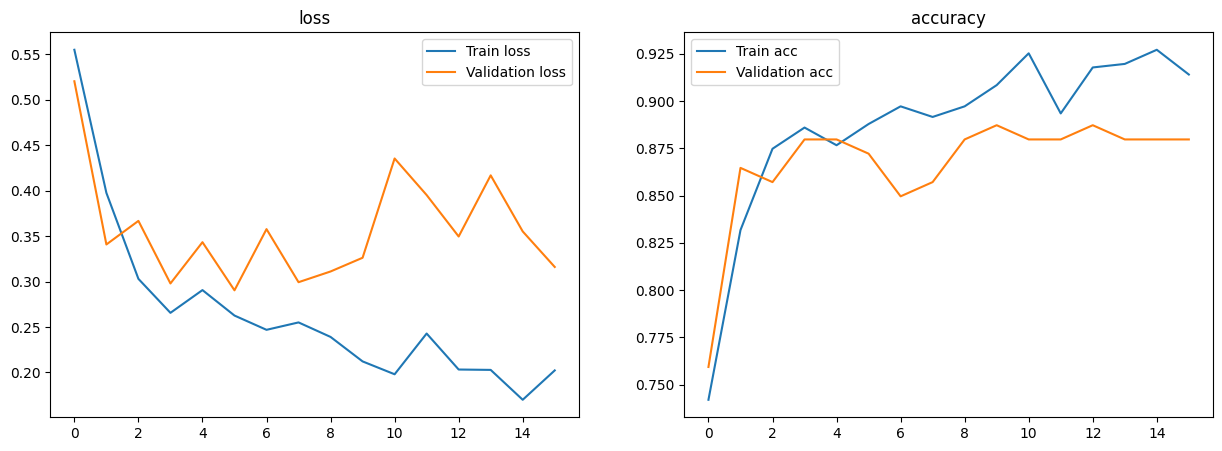

In [44]:
plot_history(history_eff_improved)

In [45]:

# Evaluate the model on test_dataset
loss, accuracy = model_eff.evaluate(test_dataset_rgb)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9112 - loss: 0.2797
Test Loss: 0.30157461762428284
Test Accuracy: 0.8899999856948853


In [53]:
predictions = model_eff.predict(test_dataset_rgb)
print(predictions)
print (predictions[:,1])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[2.64942646e-01 7.35057354e-01]
 [9.94939208e-01 5.06082643e-03]
 [5.52238524e-01 4.47761476e-01]
 [3.30121487e-01 6.69878483e-01]
 [9.29563105e-01 7.04368427e-02]
 [7.97515959e-02 9.20248389e-01]
 [5.46646953e-01 4.53353018e-01]
 [1.94644198e-01 8.05355847e-01]
 [7.45988414e-02 9.25401151e-01]
 [9.95402694e-01 4.59729694e-03]
 [4.98689890e-01 5.01310050e-01]
 [3.94080937e-01 6.05919063e-01]
 [2.15576693e-01 7.84423292e-01]
 [5.76316752e-02 9.42368388e-01]
 [1.63356617e-01 8.36643338e-01]
 [9.28550512e-02 9.07144964e-01]
 [1.07567370e-01 8.92432630e-01]
 [6.82192817e-02 9.31780756e-01]
 [5.63784599e-01 4.36215401e-01]
 [1.52024217e-02 9.84797537e-01]
 [8.86842906e-01 1.13157041e-01]
 [1.24329701e-01 8.75670314e-01]
 [9.76230919e-01 2.37691123e-02]
 [9.97407496e-01 2.59249797e-03]
 [9.82216954e-01 1.77830793e-02]
 [9.18070257e-01 8.19297805e-02]
 [9.18414593e-01 8.15854073e-02]
 [9.72285807e-01 2.77142134e-02]
 [9.79232252e-01 2.07677446e-02]
 [4.1

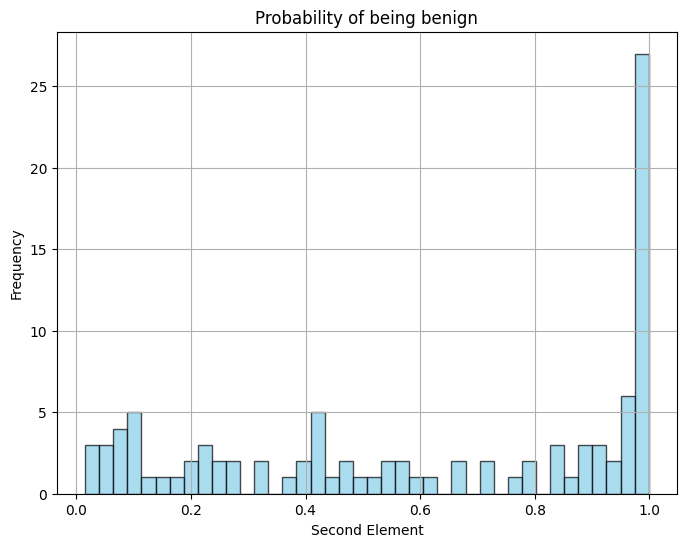

In [57]:
Probability_being_benign = predictions[:, 0]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(second_elements, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Probability of being benign')
plt.xlabel('Second Element')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


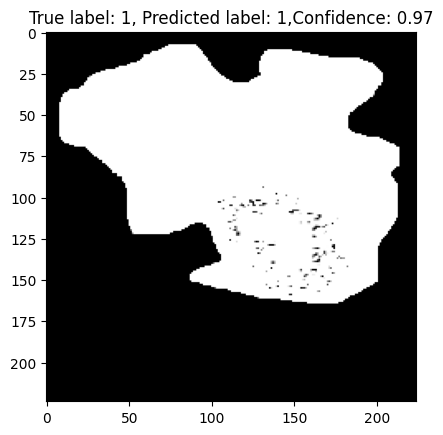

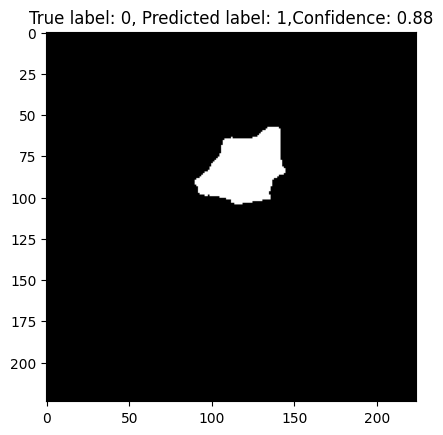

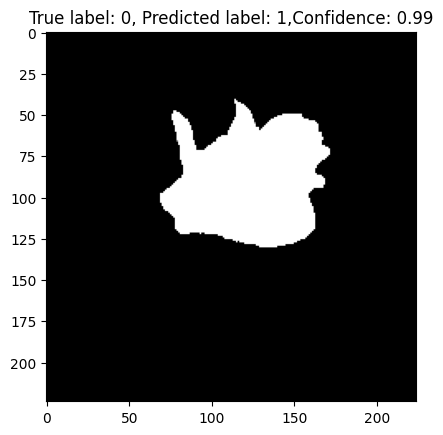

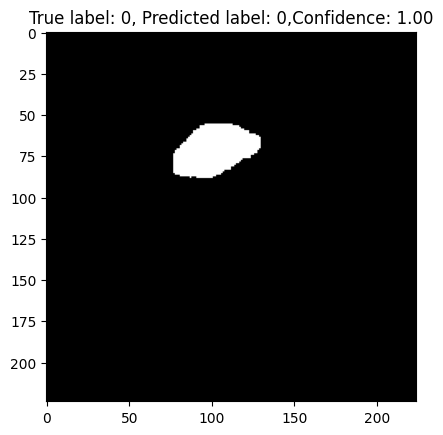

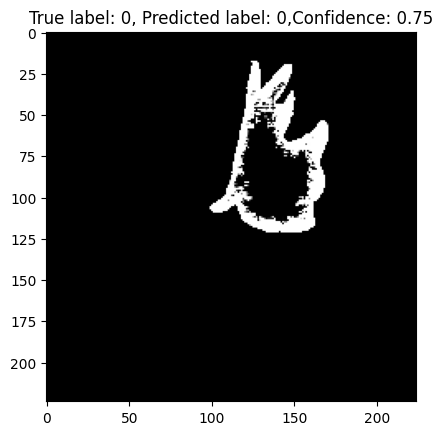

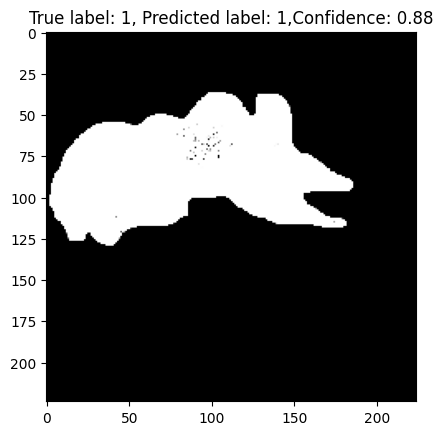

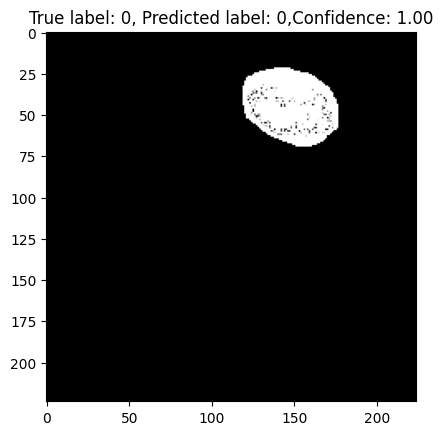

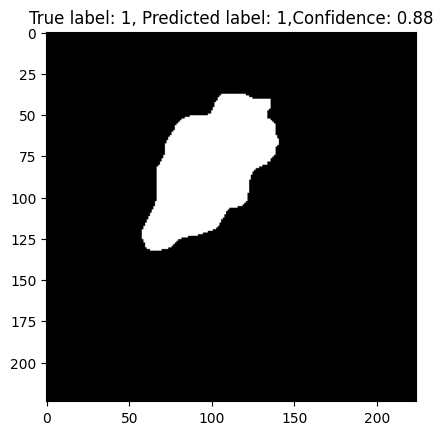

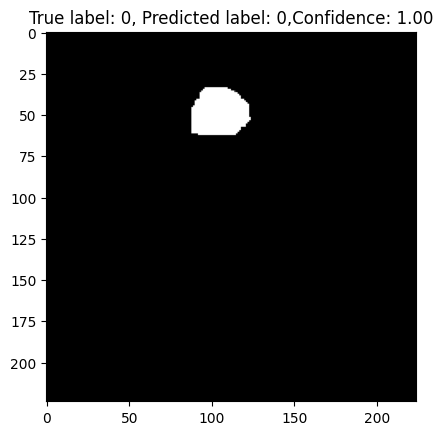

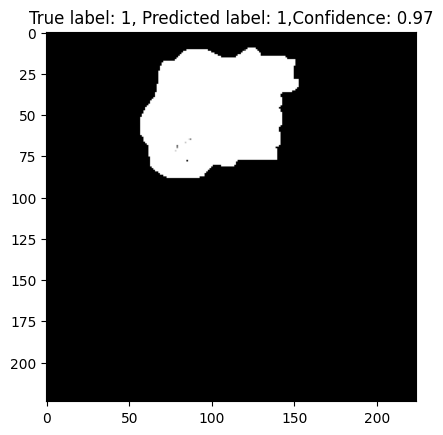

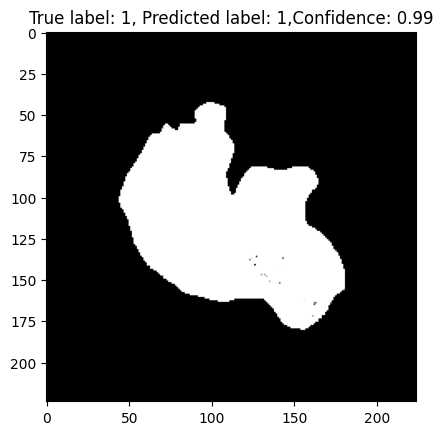

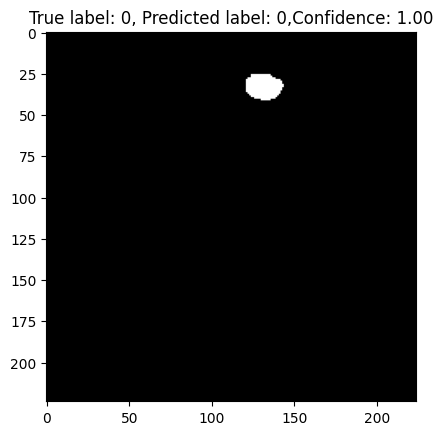

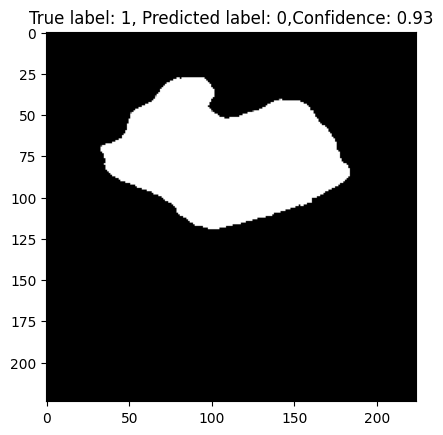

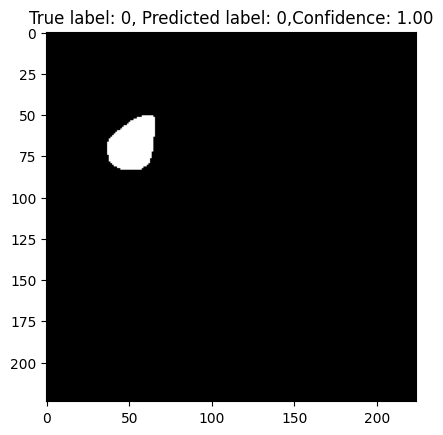

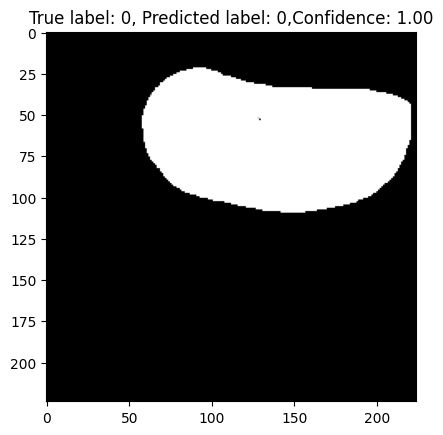

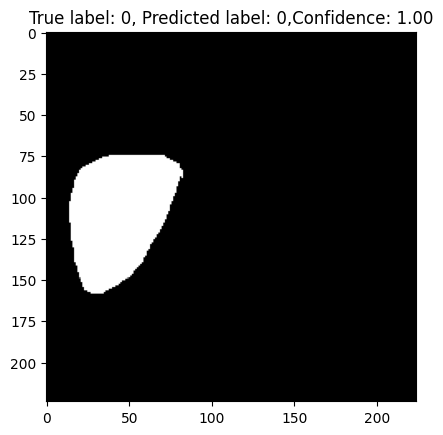

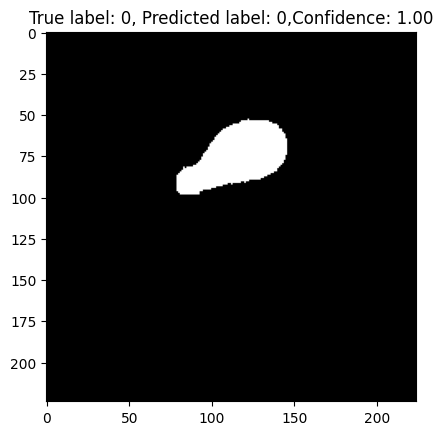

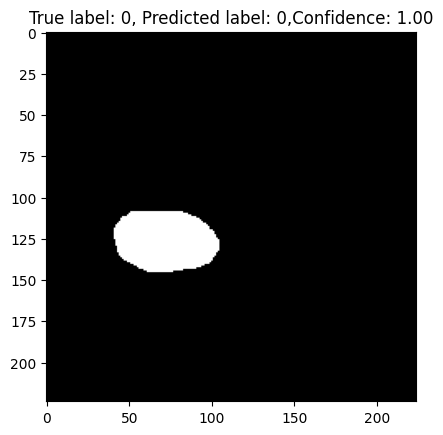

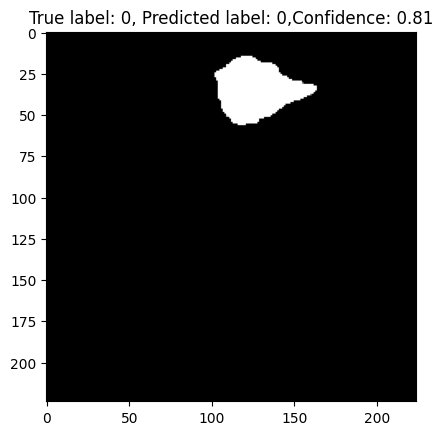

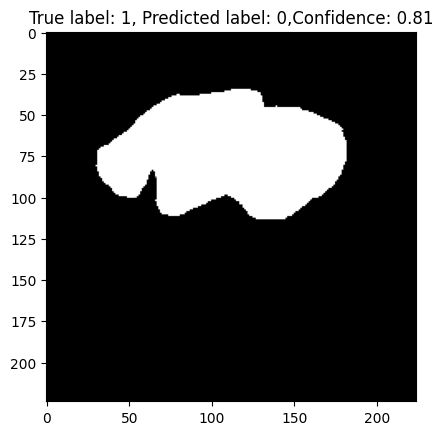

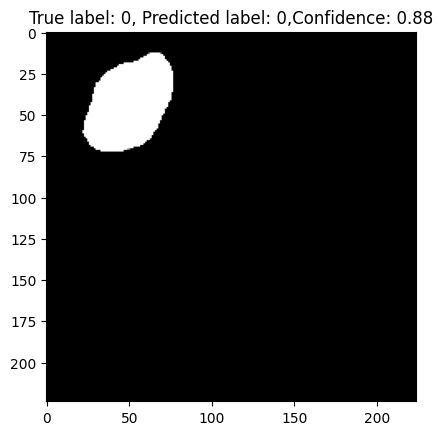

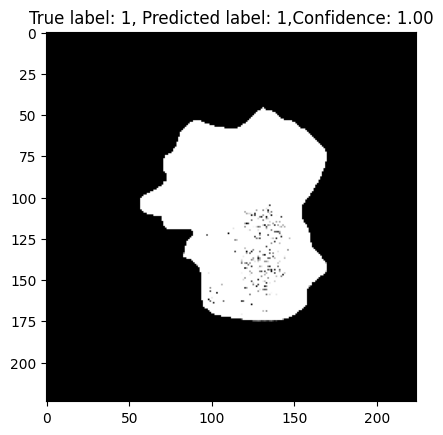

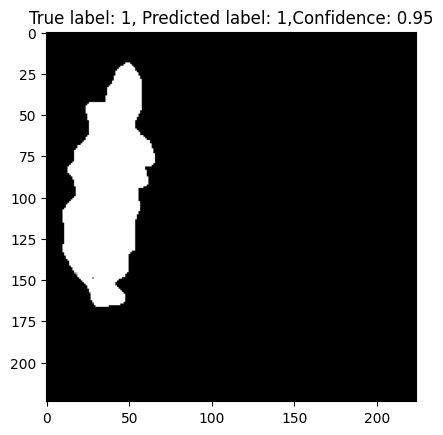

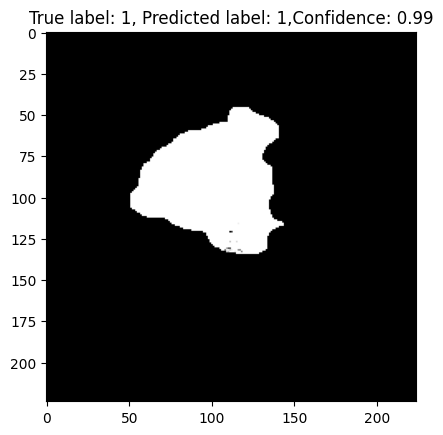

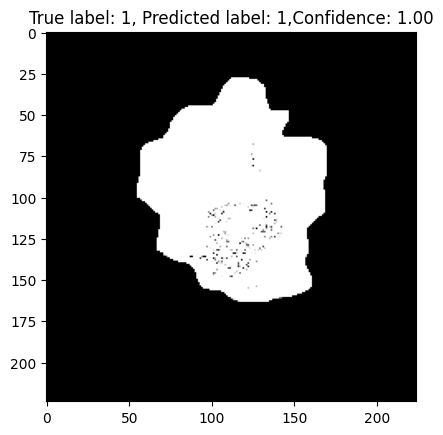

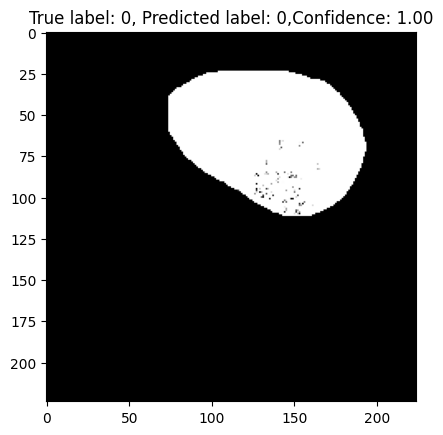

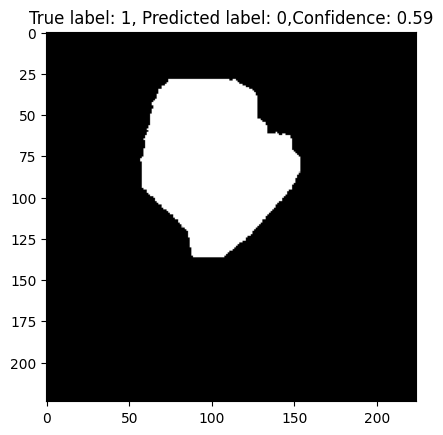

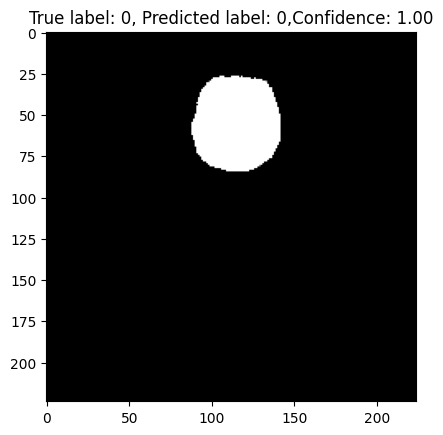

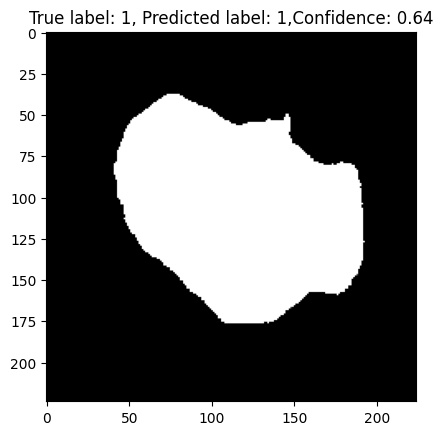

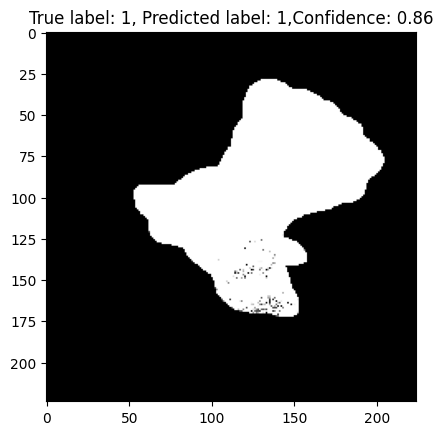

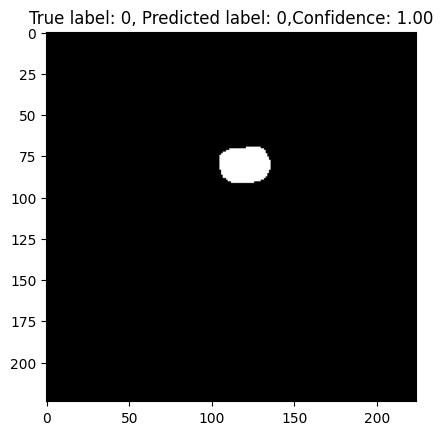

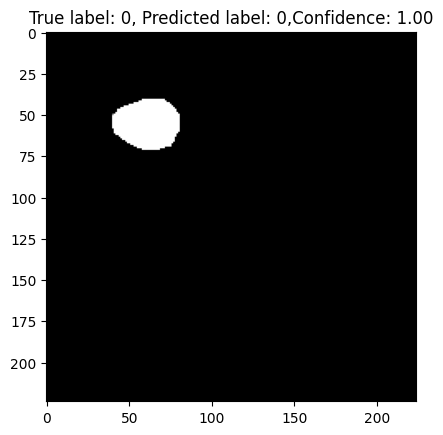

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


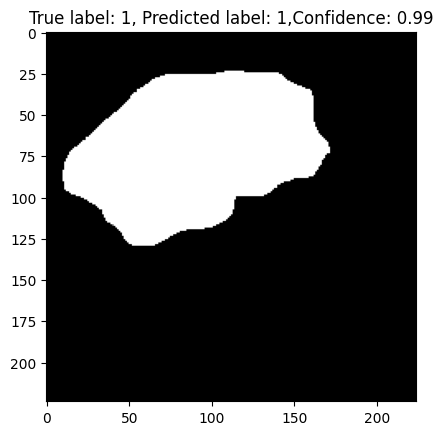

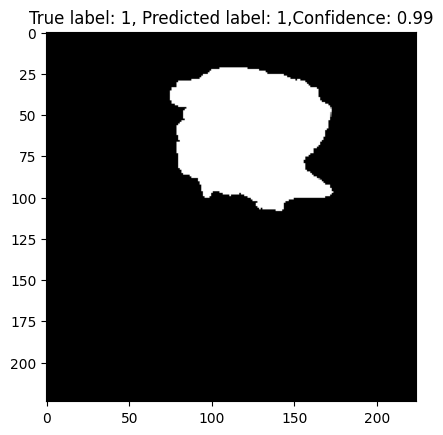

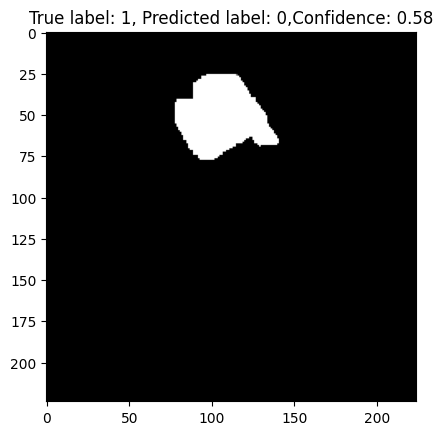

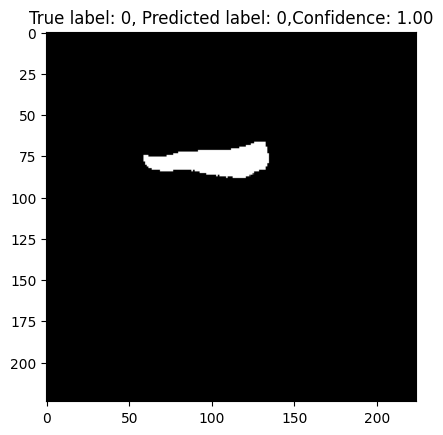

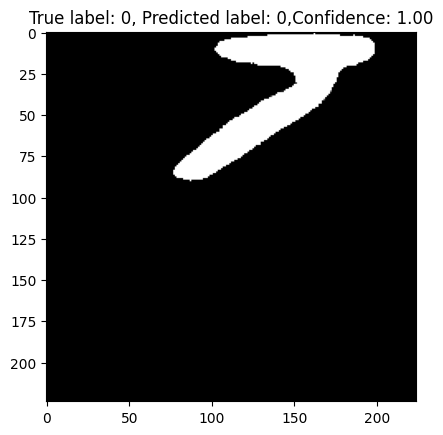

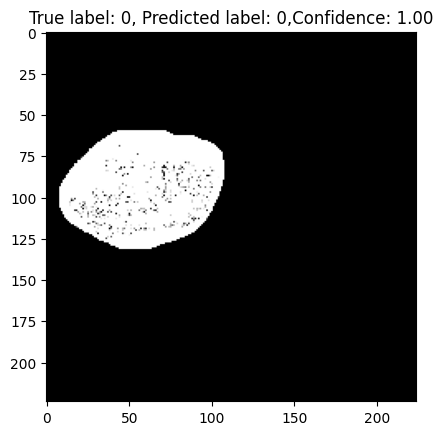

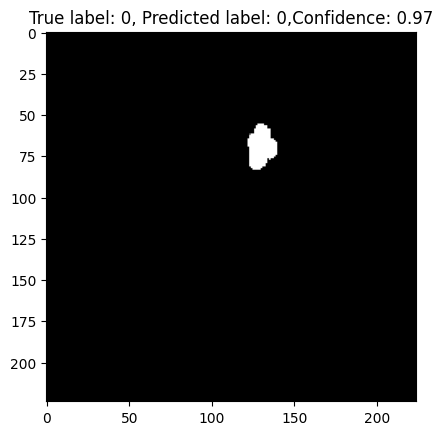

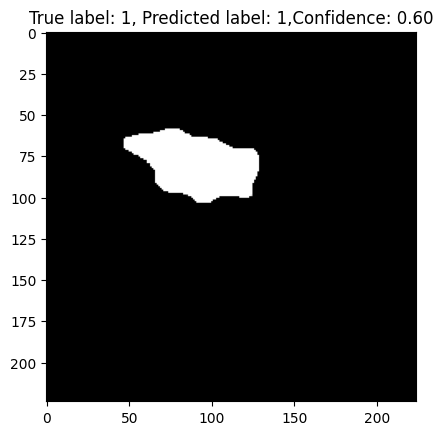

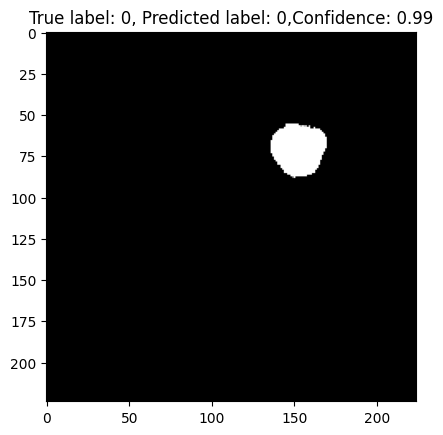

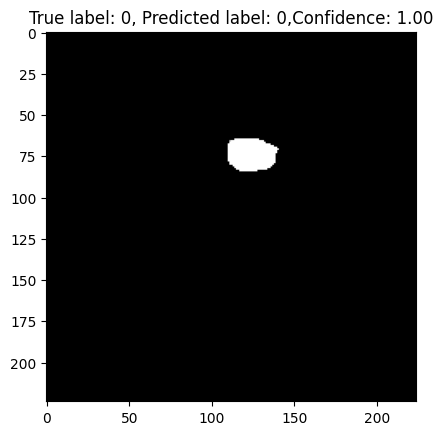

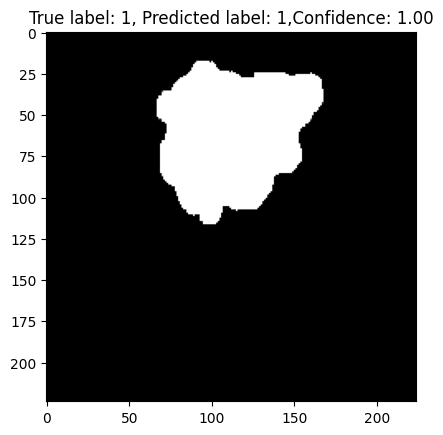

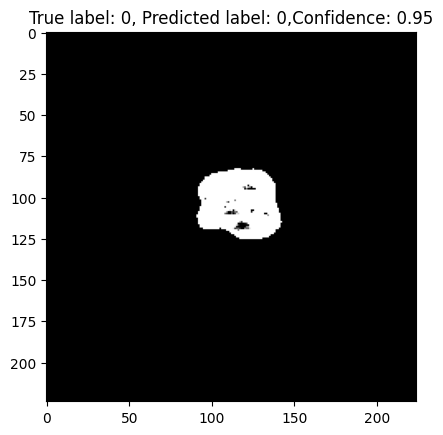

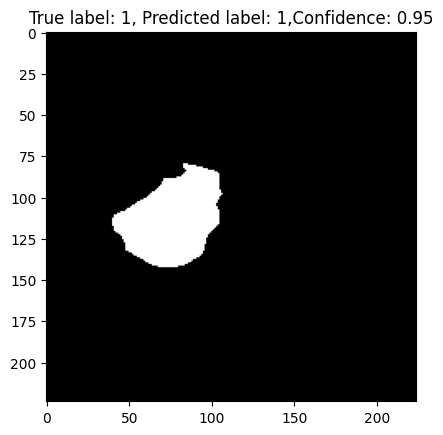

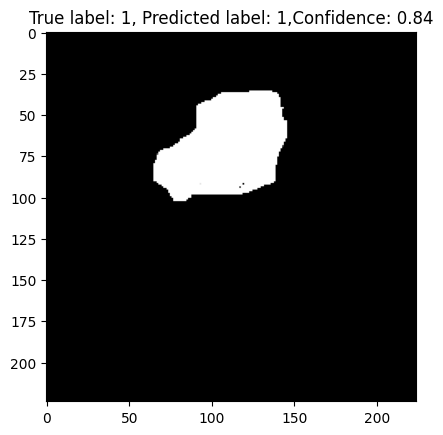

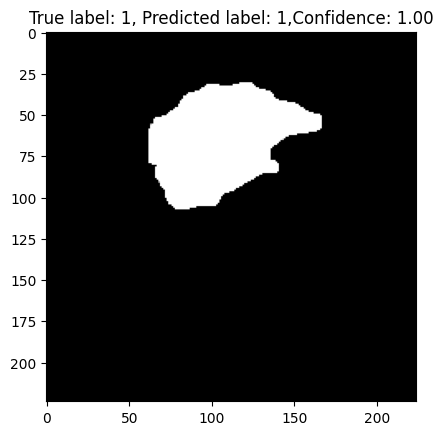

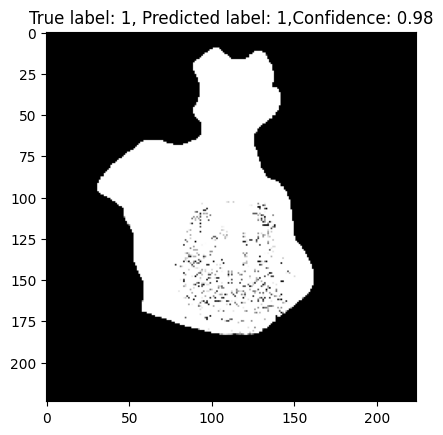

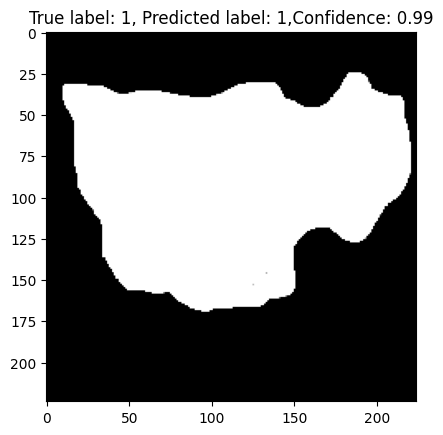

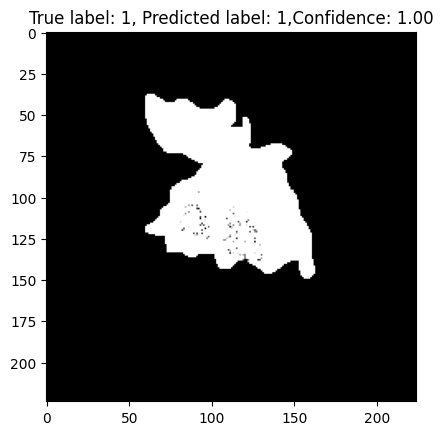

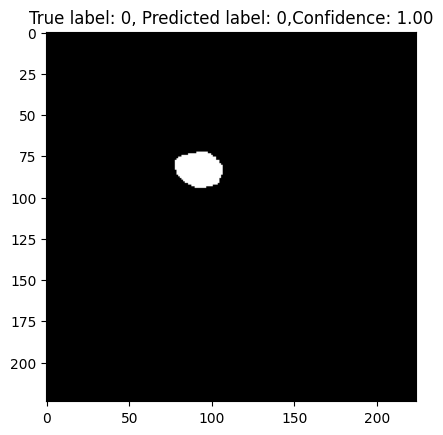

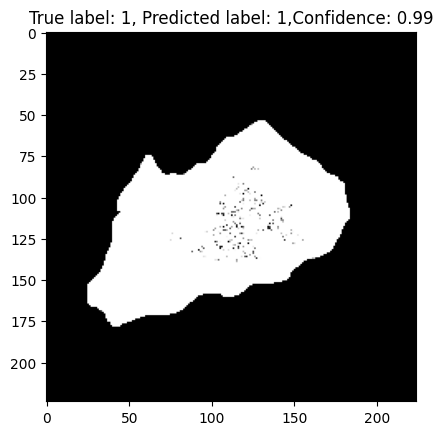

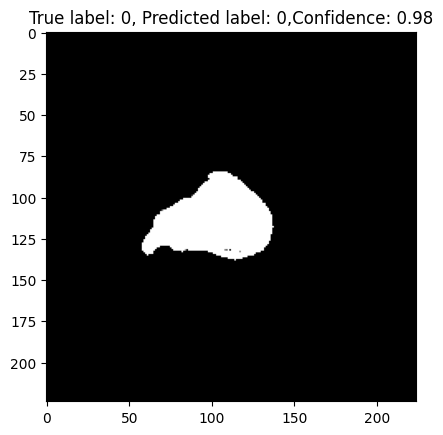

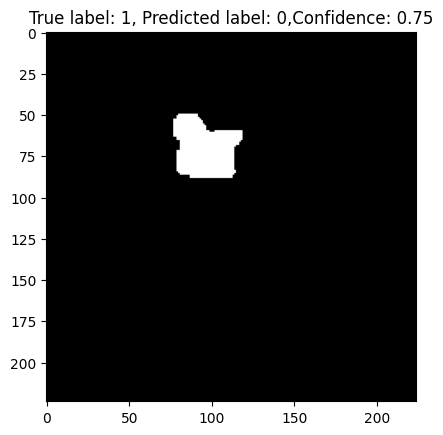

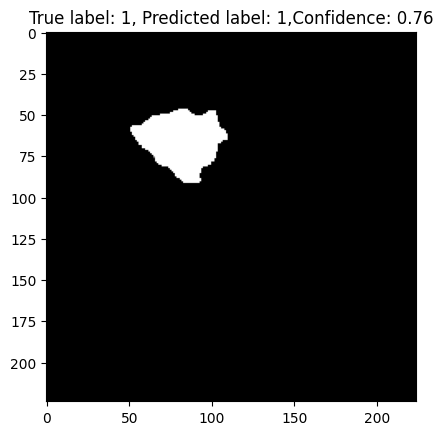

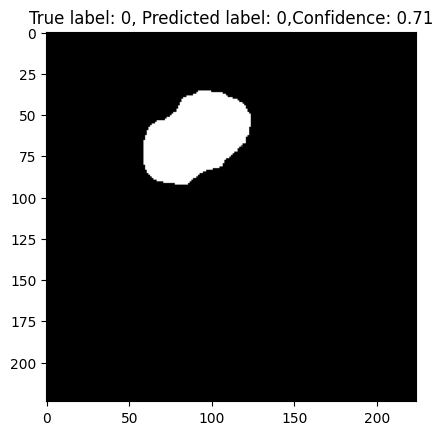

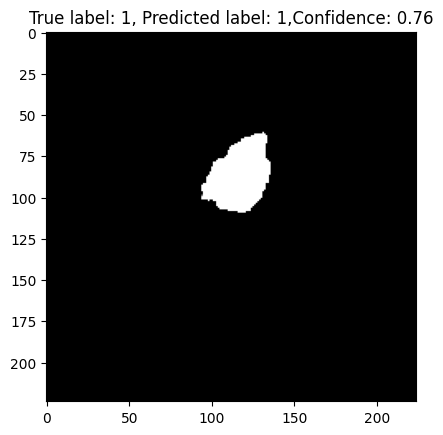

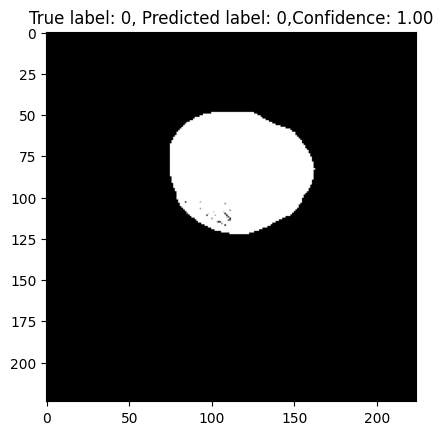

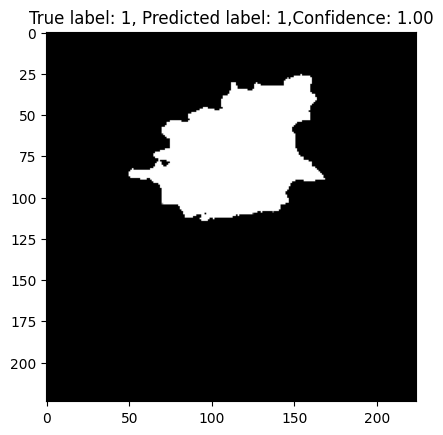

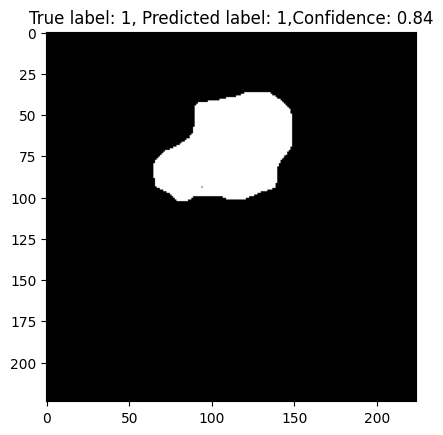

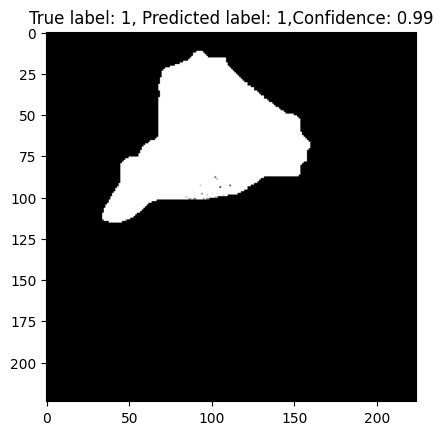

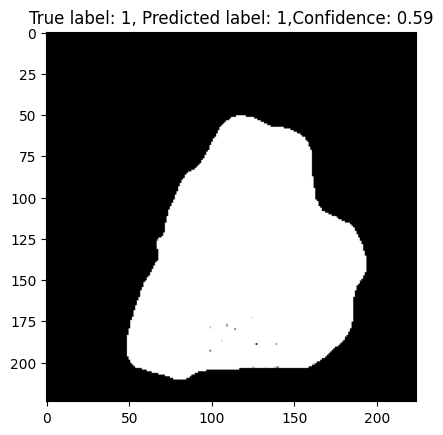

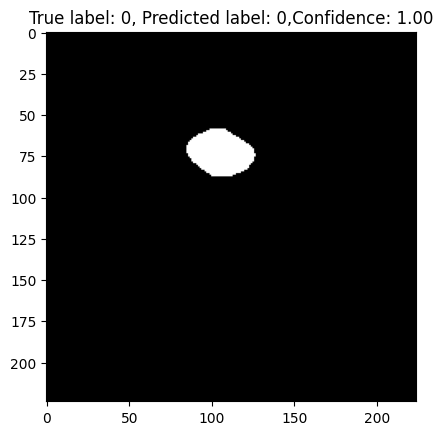

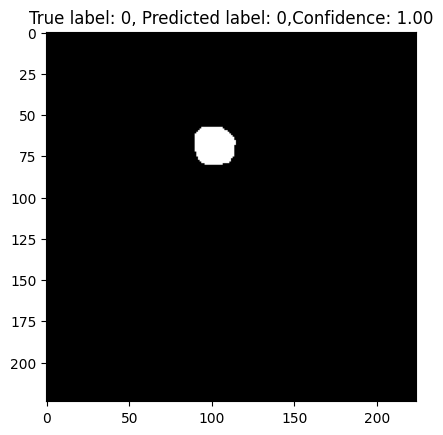

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


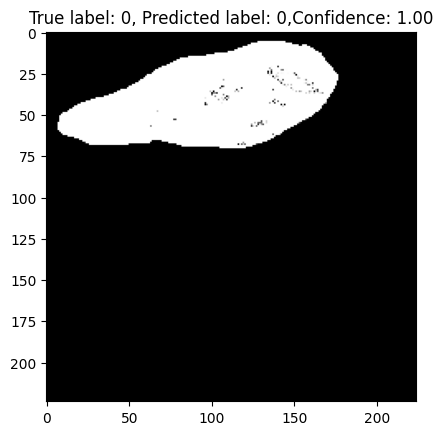

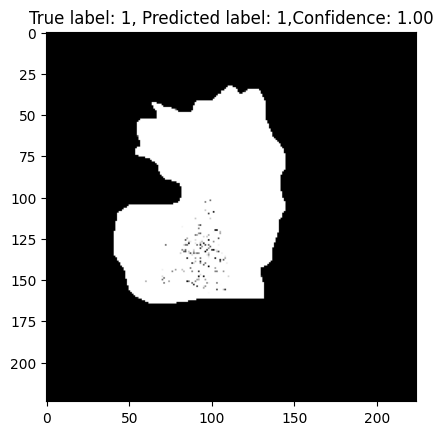

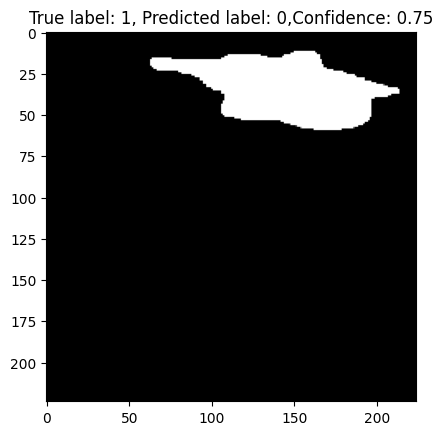

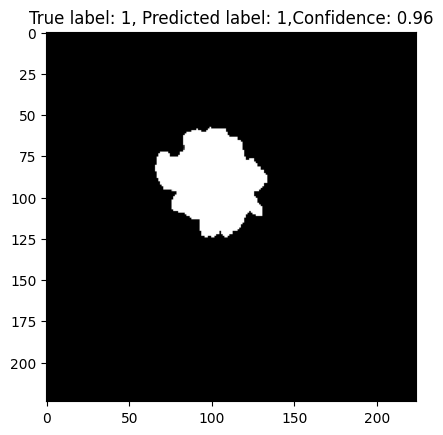

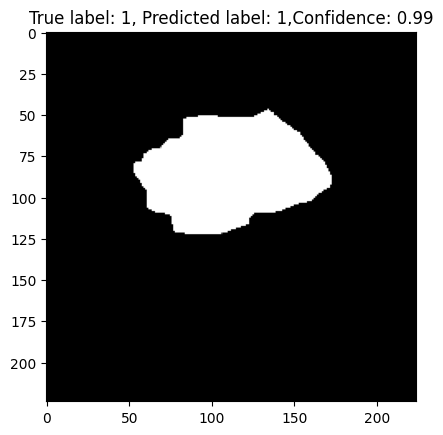

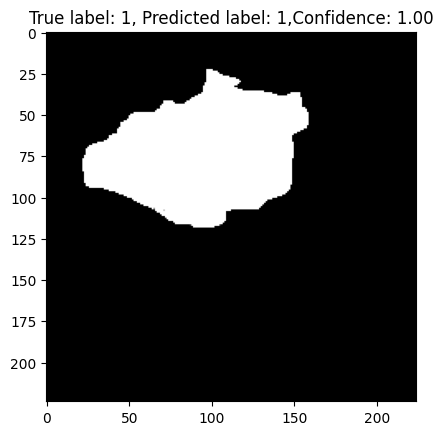

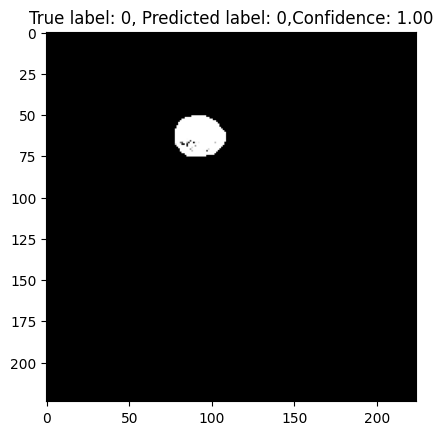

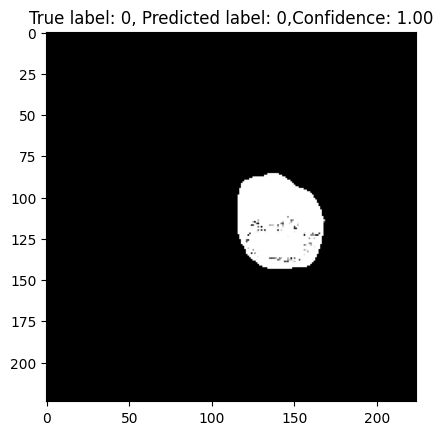

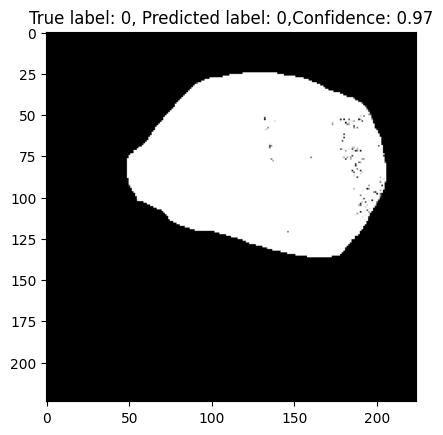

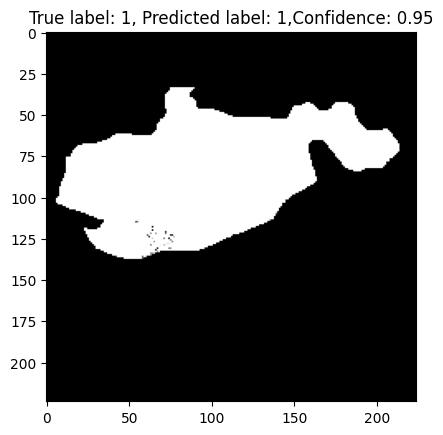

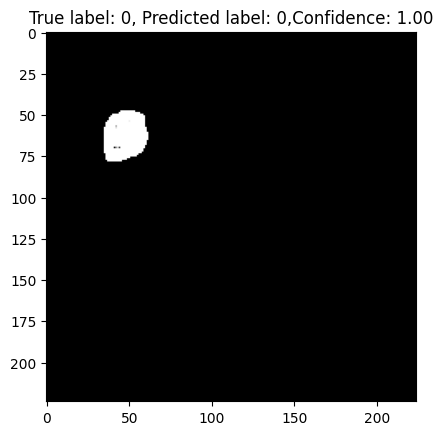

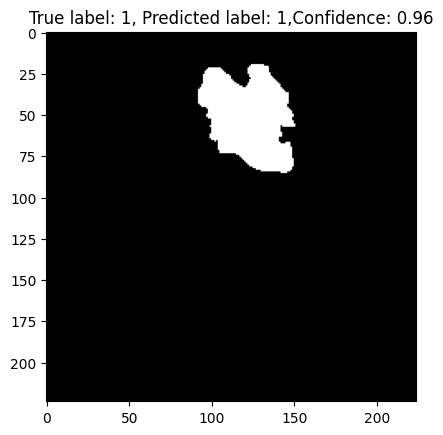

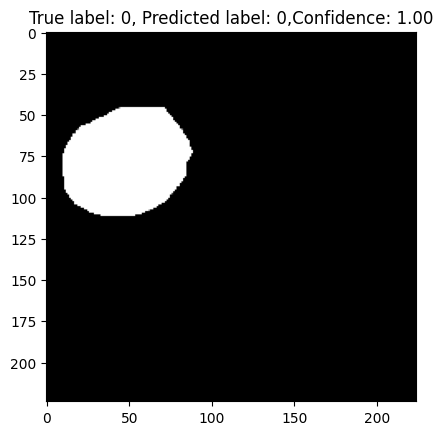

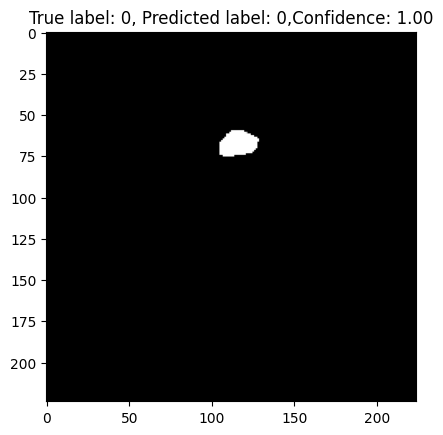

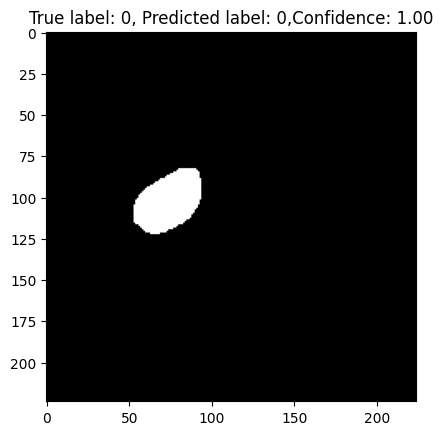

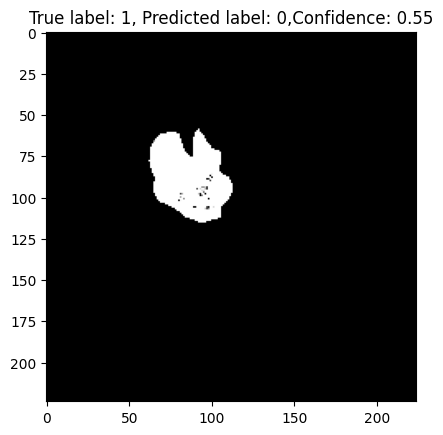

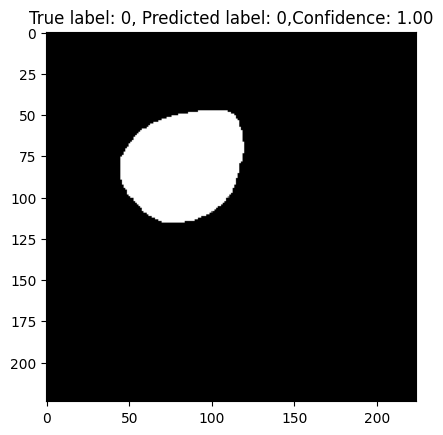

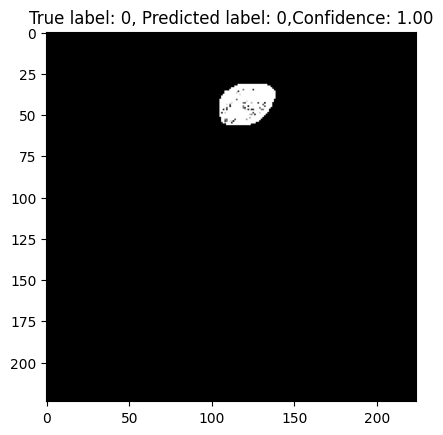

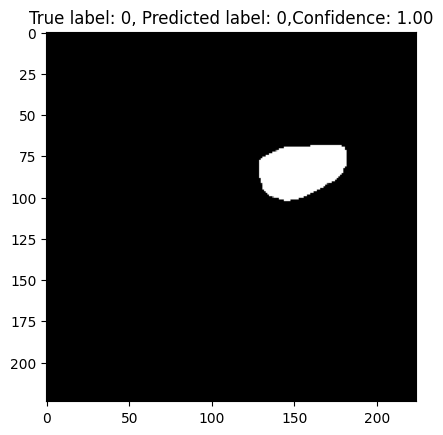

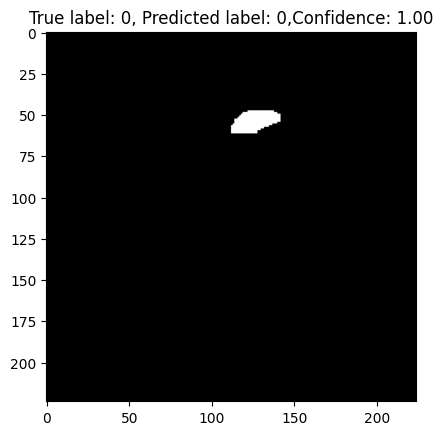

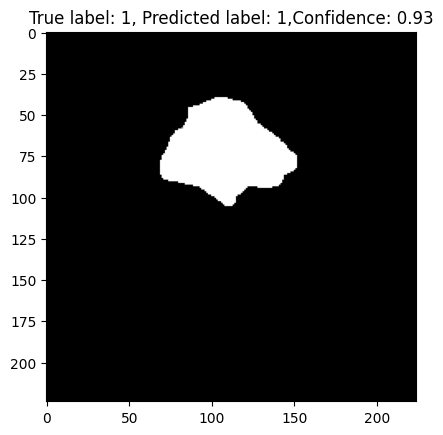

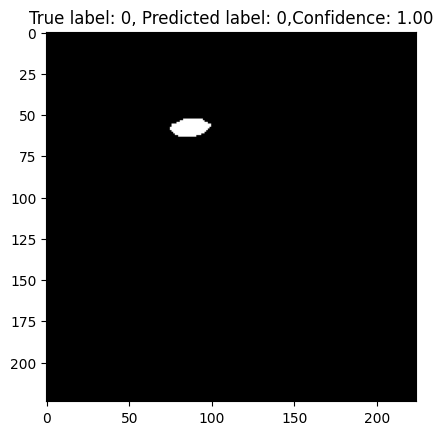

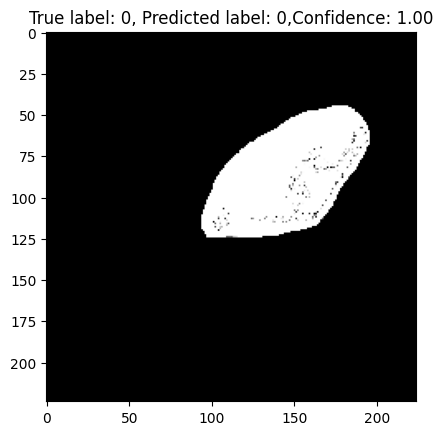

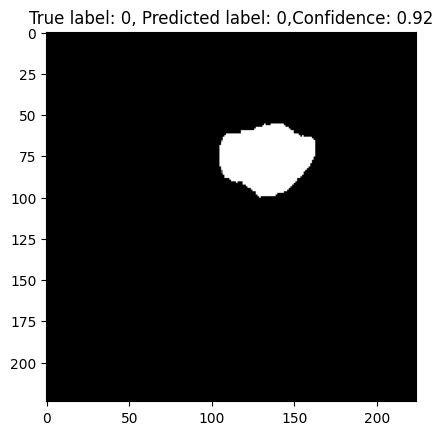

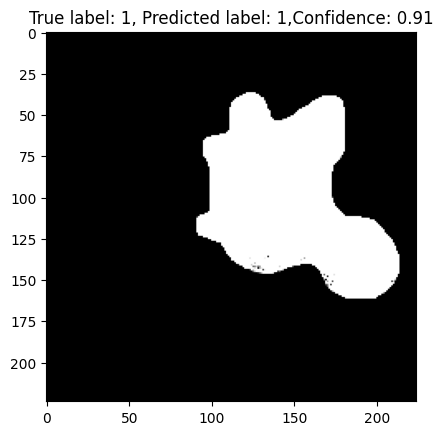

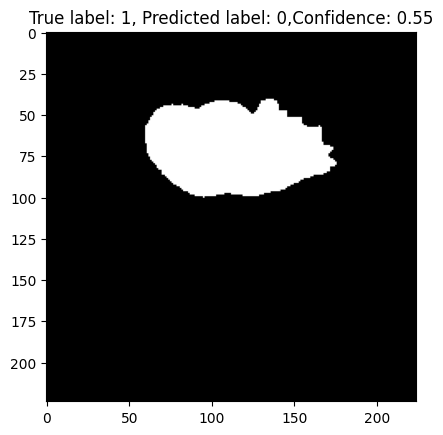

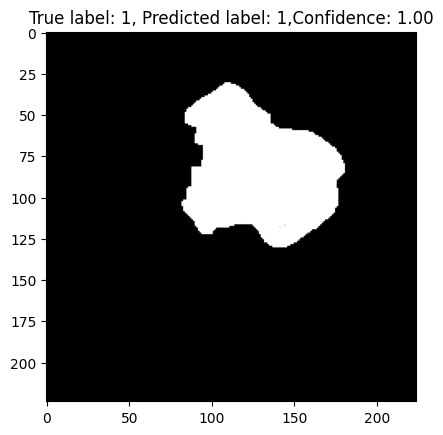

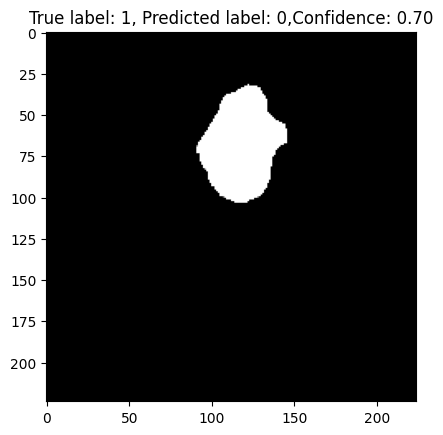

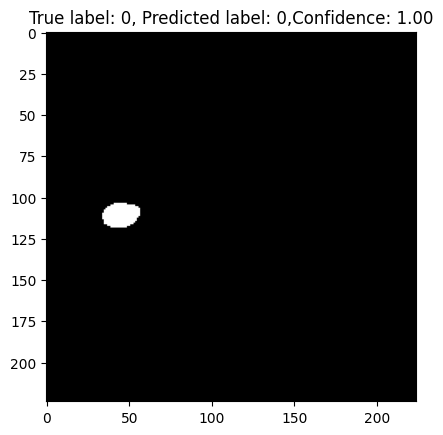

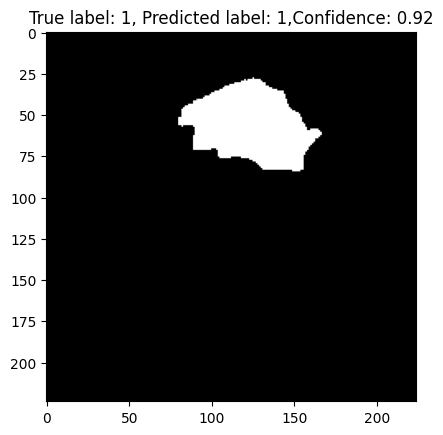

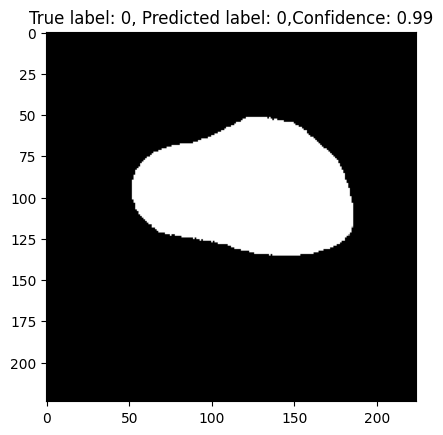

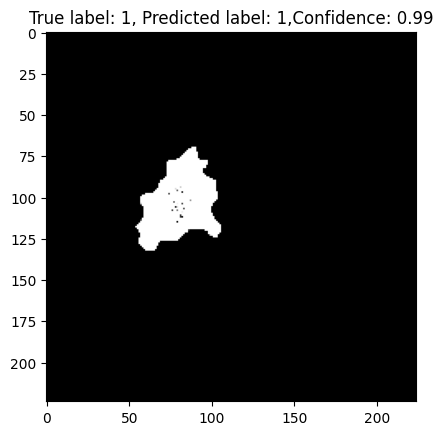

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


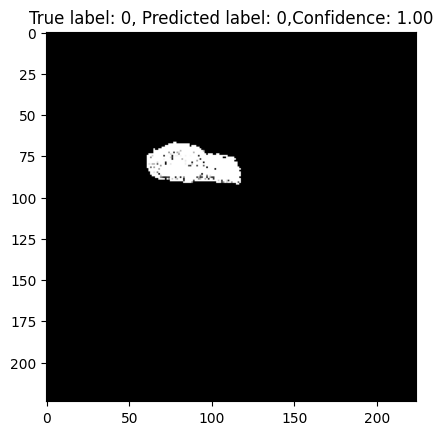

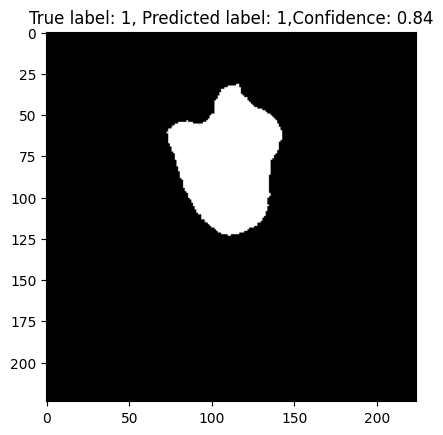

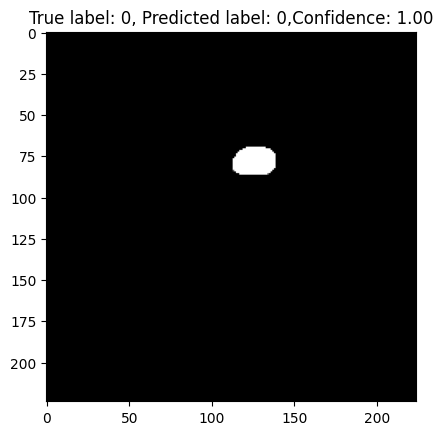

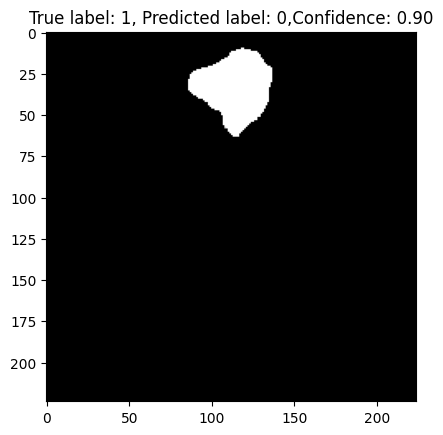

StopIteration: 

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'test_dataset_rgb' is your test dataset
# Assuming 'predictions' is the predictions made by the model

# Get test dataset iterator
test_iterator = iter(test_dataset_rgb)

# Plot images along with predictions
num_images_to_plot = 10  # Change this as needed

for _ in range(num_images_to_plot):
    test_batch = next(test_iterator)
    images, labels = test_batch
    
    batch_predictions = model_eff.predict(images)
    
    for i in range(images.shape[0]):
        image = images[i]  
        true_label = labels[i].numpy()  
        predicted_label = np.argmax(batch_predictions[i])
        confidence = batch_predictions[i][predicted_label]  # Confidence score for the predicted label
        
        # Plot the image
        plt.imshow(image)
        
        # Set title with true and predicted labels
        plt.title(f'True label: {true_label}, Predicted label: {predicted_label},Confidence: {confidence:.2f}')
        
        # Show the plot
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


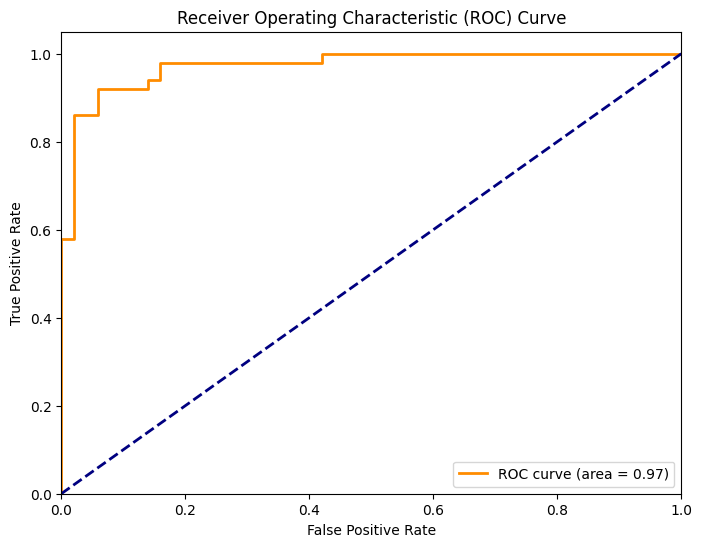

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

true_labels = []
predicted_probabilities = []

# Iterate over the dataset to collect true labels and predicted probabilities
for features, labels in test_dataset:
    predictions = model_eff.predict(features)
    true_labels.extend(labels.numpy())
    predicted_probabilities.extend(predictions[:, 1])  

# Convert lists to NP arrays
true_labels = np.array(true_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Compute the FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

# Calculate the area under the ROC curve (AUC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


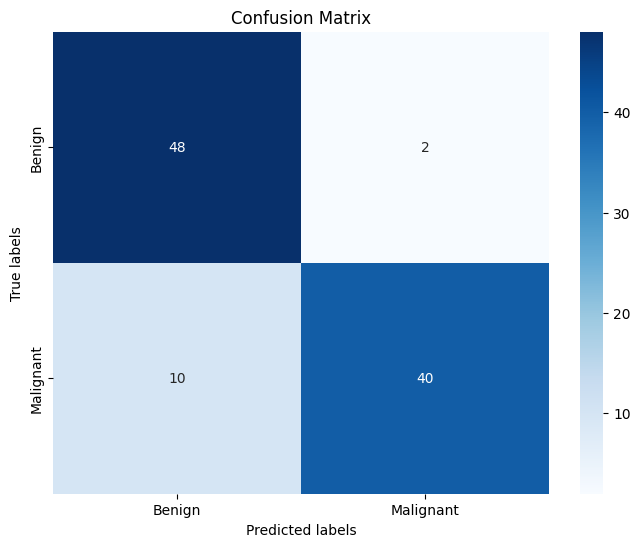

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Get true and predicted labels for all samples in the test dataset
for images, labels in test_dataset_rgb:
    batch_predictions = model_eff.predict(images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    batch_true_labels = labels.numpy()
    true_labels.extend(batch_true_labels)
    predicted_labels.extend(batch_predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [59]:
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense


# Parameters for the dataset and model
batch_size = 64
num_classes = 2  # binary classification (benign vs malignant)


input_tensor=Input(shape=(img_height, img_width, 3))

x=layers.RandomFlip("horizontal")(input_tensor)
x=layers.RandomZoom([0.1, 0.3] )(x)
x=layers.RandomTranslation(0.3, 0.3)(x)
x=layers.RandomRotation([-1,1])(x)



#x=layers.RandomFlip("horizontal")(input_tensor)
#x=layers.RandomZoom(0.1)(x)
#x=layers.RandomTranslation(0.2, 0.2)(x)
#x=layers.RandomRotation(0.1)(x)



# Load the pre-trained EfficientNetB0 model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)(x)

# Freeze the pre-trained layers
base_model.trainable = False


# Add custom classification head
x = GlobalAveragePooling2D()(base_model)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)



# Create the model
model_eff = Model(inputs=input_tensor, outputs=output)

# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Display the model summary
model_eff.summary()

# Assuming you have defined your training and validation datasets
# Replace `train_dataset` and `val_dataset` with your actual datasets



#This callback will save the model to a file after every epoch
model_checkpoint = callbacks.ModelCheckpoint("model_best.keras", monitor='val_loss', verbose=0, save_best_only=True)

#This callback reduces the learning rate when a metric has stopped improving.
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

#This callback will stop the training if the monitored metric (in this case, validation loss) does not improve.
early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)





# Train the model

history_eff_improved= model_eff.fit(dataset_rgb,
                    validation_data=validation_dataset_rgb,
                    epochs=50,  batch_size=batch_size, callbacks=[model_checkpoint, lr_reducer, early_stopper]
                          )

# Evaluate the model
loss, accuracy = model_eff.evaluate(validation_dataset_rgb)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_3            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 23,797,122 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 822ms/step - accuracy: 0.6971 - loss: 0.5572 - val_accuracy: 0.8797 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - accuracy: 0.8805 - loss: 0.3191 - val_accuracy: 0.8647 - val_loss: 0.5807 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.9046 - loss: 0.2555 - val_accuracy: 0.7368 - val_loss: 1.2357 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.8880 - loss: 0.2426 - val_accuracy: 0.8872 - val_loss: 0.5671 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.9013 - loss: 0.2492 - val_accuracy: 0.9023 - val_loss: 0.7050 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.8876 - loss: 0.2868 - val_accuracy: 0.8872 - val_loss: 0.3393 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy

In [60]:
loss, accuracy = model_eff.evaluate(test_dataset_rgb)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.8635 - loss: 0.2682
Test Loss: 0.25675320625305176
Test Accuracy: 0.8799999952316284
